## Notebook Information

**Master in Quantum Computing - UNIR**

**Subject:** Algebra in Quantum Computing

**Notebook Activity by:** Albert Nieto Morales

**Date:** 2024-01-15

---

*Note: This notebook is part of the Master's program in Quantum Computing at UNIR. The content focuses on Quantum Computing and was created by Albert Nieto. Please refer to the date for the latest update.*


# Librerias y enunciados

## Librerias

Las librerías que se van a utilizar son:

- **NumPy:** Biblioteca fundamental de Python para computación numérica y manipulación de arrays multidimensionales. Proporciona funciones y herramientas para realizar operaciones matemáticas complejas de manera eficiente.

- **math:** Módulo incorporado de Python que ofrece funciones matemáticas estándar para operaciones con números reales, como trigonometría, álgebra, funciones exponenciales y logaritmos.

- **cmath:** Módulo incorporado de Python que proporciona funciones matemáticas para operaciones con números complejos, incluyendo cálculo del valor absoluto, fase, exponenciación, logaritmos y otras operaciones específicas para números complejos.

- **Qiskit:** Conjunto de herramientas de código abierto desarrollado por IBM para trabajar con computación cuántica en Python. Permite la creación, manipulación y ejecución de circuitos cuánticos, así como la simulación y conexión con procesadores cuánticos reales disponibles en la nube.

In [1]:
%%capture
%pip install qiskit
%pip install qiskit-ibmq-provider
%pip install qiskit-aer

In [2]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization.bloch import Bloch
from qiskit_ibm_provider import IBMProvider

# Importing matplotlib
import matplotlib.pyplot as plt

# Importing Numpy, Cmath and math
import numpy as np
import math, cmath

# Other imports
from IPython.display import display, Math, Latex
from itertools import product

# Loading your IBM Quantum account(s)
IBMProvider.save_account("", overwrite=True)

# Run the quantum circuit on a statevector simulator backend
backend = Aer.get_backend("statevector_simulator")

## Enunciado

Con esta actividad verás la facilidad de generar un circuito de una función booleana utilizando la función clásica de qiskit.circuit.

## Funciones auxiliares

Estas funciones se utilizarán en varios ejercicios. Estas funciones son propias realizadas para esta actividad, están disponible en [mi repositorio](https://github.com/albertnieto/quantum-helper).

Creamos una función para representar en latex una matriz:

In [3]:
def matrix_to_latex(matrix, prefix=""):
    """
    Convert a NumPy matrix to its LaTeX representation.

    Parameters:
    - matrix (numpy.ndarray): The input matrix.
    - prefix (str): A string to be prepended to the LaTeX representation.

    Returns:
    IPython.display.Math: LaTeX representation of the matrix.
    """
    latex_code = f"{prefix}\\begin{{bmatrix}}\n"

    for row in matrix:
        latex_code += " & ".join(map(str, row))
        latex_code += " \\\\\n"

    latex_code += "\\end{bmatrix}"

    return Math(latex_code)

Y otra función para pasar de una matriz de complejos a una matriz de texto para poder representarlo formateado:

In [4]:
def complex_matrix_to_string(matrix):
    """
    Transform a matrix of complex numbers to strings truncated to 4 decimals.

    Parameters:
    - matrix (numpy.ndarray): The input matrix of complex numbers.

    Returns:
    numpy.ndarray: Matrix of strings.
    """

    def format_complex_number(x):
        if x.real == 0 and x.imag == 0:
            return "0"
        elif x.real == 0:
            return f"{x.imag:.4f}i"
        elif x.imag == 0:
            return f"{x.real:.4f}"
        else:
            return (
                f"{x.real:.4f} + {x.imag:.4f}i"
                if x.imag >= 0
                else f"{x.real:.4f} - {-x.imag:.4f}I"
            )

    formatted_matrix = np.vectorize(format_complex_number)(matrix)
    return formatted_matrix

Ya que la función de qiskit `plot_bloch_vector´ [no soporta diversos vectores en la misma esfera de Bloch](https://github.com/Qiskit/qiskit/issues/5021)
, se define manualmente una función para representarlo:

In [5]:
from qiskit.visualization.bloch import Bloch


def plot_bloch_multiple_vector(bloch_data, title="Bloch Sphere", font_size=16):
    """
    Plots multiple vectors on a Bloch sphere.

    Parameters:
    - bloch_data (dict): A dictionary where keys are labels for the vectors, and values are 3D vectors
                        representing the points to plot on the Bloch sphere.
    - title (str, optional): The title of the plot. Default is 'Bloch Sphere'.
    - font_size (int, optional): Font size for the annotations on the Bloch sphere. Default is 16.

    Returns:
    - fig (matplotlib.figure.Figure): The matplotlib figure object representing the Bloch sphere plot.
    """

    fig, ax = plt.subplots(subplot_kw=dict(projection="3d"))

    B = Bloch(axes=ax, font_size=font_size)
    B.zlabel = ["z", ""]

    for key, value in bloch_data.items():
        B.add_vectors([value])
        B.add_annotation(value, key)

    B.render(title=title)

    return fig

También definimos una función para obtener las coordenadas de la esfera de Bloch a partir de un estado de un cúbit:

In [49]:
def compute_bloch_vector(state_vector):
    """
    Calculate the Bloch vector coordinates from a given state matrix.

    Parameters:
    - state_matrix (numpy.ndarray): A 2x2 complex-valued matrix representing the quantum state.

    Returns:
    - list: A list containing the Bloch vector coordinates [x, y, z].

    Note:
    The Bloch vector coordinates (x, y, z) are computed from the coefficients (alpha, beta)
    of the quantum state, where the state matrix is of the form:
        | alpha |^2 - | beta |^2
        2 * Re(conj(alpha) * beta)
        2 * Im(conj(alpha) * beta)

    The resulting coordinates represent the vector on the Bloch sphere corresponding to the quantum state.
    """

    alpha, beta = state_vector[:, 0]

    x = round(2 * np.real(alpha * np.conj(beta)), 10)
    y = round(2 * np.imag(alpha * np.conj(beta)), 10)
    z = round(np.abs(alpha) ** 2 - np.abs(beta) ** 2, 10)

    return [x, y, z]

[[0.+0.j]
 [0.+1.j]] [0.0, 0.0, -1.0]


# Ejercicio 1

Halla el producto tensorial de matrices, en particular, de las matrices unitarias vistas en el tema 5. Encuentra:

$$Z \otimes I \otimes Z \otimes I$$
$$I \otimes Z \otimes I \otimes Z$$
$$I \otimes Z \otimes I$$


Definimos Z e I como:

$Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \\ \end{bmatrix}$, $I = \begin{bmatrix} 1 & 0 \\ 0 & 1 \\ \end{bmatrix}$


In [ ]:
matrix_z = np.array([[1, 0], [0, -1]])
matrix_i = np.array([[1, 0], [0, 1]])

## Producto tensorial 1

Para $Z \otimes I \otimes Z \otimes I$

Para calcular el producto tensorial de varias matrices, podemos aplicar la propiedad asociativa del producto tensorial:

$$(Z \otimes I \otimes Z \otimes I) = (Z \otimes I) \otimes (Z \otimes I)$$

Primero calculamos $Z \otimes I$ y lo llamamos M:

$$M = Z \otimes I = \begin{bmatrix} 1 \cdot I & 0 \cdot I \\ 0 \cdot I & -1 \cdot I \end{bmatrix} = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & -1 \\ \end{bmatrix}$$

In [ ]:
matrix_m = np.kron(matrix_z, matrix_i)
matrix_to_latex(matrix_m, prefix="M =")

<IPython.core.display.Math object>

Teniendo $M = Z \otimes I$, podemos calcular $(Z \otimes I) \otimes (Z \otimes I)$ como $M \otimes M$

In [ ]:
tp1 = np.kron(matrix_m, matrix_m)
matrix_to_latex(tp1, prefix="Z \otimes I \otimes Z \otimes I =")

<IPython.core.display.Math object>

## Producto tensorial 2

Para $I \otimes Z \otimes I \otimes Z$

Para calcular el producto tensorial, podemos aplicar de nuevola propiedad asociativa:

$$(I \otimes Z \otimes I \otimes Z) = (I \otimes Z) \otimes (I \otimes Z)$$

Primero calculamos $I \otimes Z$ y lo llamamos N:

$$N = I \otimes Z = \begin{bmatrix} 1 \cdot Z & 0 \cdot Z \\ 0 \cdot Z & 1 \cdot Z \end{bmatrix} = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & -1 \\ \end{bmatrix}$$


In [ ]:
matrix_n = np.kron(matrix_i, matrix_z)
matrix_to_latex(matrix_n, prefix="N =")

<IPython.core.display.Math object>

Teniendo $N = I \otimes Z$, podemos calcular $(I \otimes Z) \otimes (I \otimes Z)$ como $N \otimes N$

In [ ]:
tp2 = np.kron(matrix_n, matrix_n)
matrix_to_latex(tp2, prefix="I \otimes Z \otimes I \otimes Z =")

<IPython.core.display.Math object>

## Producto tensorial 3

Para $I \otimes Z \otimes I$

Utilizamos de nuevo la propiedad asociativa:

$$(I \otimes Z \otimes I) = (I \otimes Z) \otimes I$$

Y reutilizamos la matriz N del anterior producto tensorial:

$$N = I \otimes Z = \begin{bmatrix} 1 \cdot Z & 0 \cdot Z \\ 0 \cdot Z & 1 \cdot Z \end{bmatrix} = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & -1 \\ \end{bmatrix}$$


In [ ]:
matrix_n = np.kron(matrix_i, matrix_z)
matrix_to_latex(matrix_n, prefix="N =")

<IPython.core.display.Math object>

De la misma manera, resolvemos:

$$ N \otimes I = \begin{bmatrix} 1 \cdot I & 0 \cdot I & 0 \cdot I & 0 \cdot I \\ 0 \cdot I & -1 \cdot I & 0 \cdot I & 0 \cdot I \\ 0 \cdot I & 0 \cdot I & 1 \cdot I & 0 \cdot I \\ 0 \cdot I & 0 \cdot I & 0 \cdot I & -1 \cdot I \end{bmatrix} = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & -1 \end{bmatrix} \otimes \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} $$


In [ ]:
tp3 = np.kron(matrix_n, matrix_i)
matrix_to_latex(tp3, prefix="I \otimes Z \otimes I =")

<IPython.core.display.Math object>

# Ejercicio 2

Calcula:

$$ \frac{3}{4} Z \otimes Z \otimes I + \frac{2}{3} Z \otimes I \otimes Z - \frac{4}{5} X \otimes Y \otimes Z - I \otimes I \otimes Z $$

y 

$$\langle 111 | \left(\frac{3}{4} Z \otimes Z \otimes I + \frac{2}{3} Z \otimes I \otimes Z - \frac{4}{5} X \otimes Y \otimes Z - I \otimes I \otimes Z\right) | 111 \rangle$$


Definimos las matrices I, X, Y y Z:
$$I = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}, X = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}, Y = \begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix}, Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}$$

In [ ]:
matrix_i = np.array([[1, 0], [0, 1]])
matrix_x = np.array([[0, 1], [1, 0]])
matrix_y = np.array([[0, -1j], [1j, 0]])
matrix_z = np.array([[1, 0], [0, -1]])

## Cálculo 1

Calcula:

$$ \frac{3}{4} Z \otimes Z \otimes I + \frac{2}{3} Z \otimes I \otimes Z - \frac{4}{5} X \otimes Y \otimes Z - I \otimes I \otimes Z $$


A la matriz resultante, le llamaremos Matriz A, y para simplificar los cálculos, agruparemos con paréntesis los grupos de productos tensoriales:

$$ A = (\frac{3}{4} Z \otimes Z \otimes I) + (\frac{2}{3} Z \otimes I \otimes Z) - (\frac{4}{5} X \otimes Y \otimes Z) - (I \otimes I \otimes Z) $$

Primero calculamos los paréntesis por separado: 

In [ ]:
parenthesis_1 = np.kron((3 / 4) * matrix_z, np.kron(matrix_z, matrix_i))
parenthesis_2 = np.kron((2 / 3) * matrix_z, np.kron(matrix_i, matrix_z))
parenthesis_3 = np.kron((4 / 5) * matrix_x, np.kron(matrix_y, matrix_z))
parenthesis_4 = np.kron(matrix_i, np.kron(matrix_i, matrix_z))

In [ ]:
matrix_a = parenthesis_1 + parenthesis_2 - parenthesis_3 - parenthesis_4
matrix_a_string = complex_matrix_to_string(matrix_a)
matrix_to_latex(matrix_a_string, prefix="A =")

<IPython.core.display.Math object>

## Cálculo 2

Calcula:

$$\langle 111 | \left(\frac{3}{4} Z \otimes Z \otimes I + \frac{2}{3} Z \otimes I \otimes Z - \frac{4}{5} X \otimes Y \otimes Z - I \otimes I \otimes Z\right) | 111 \rangle$$


Según hemos calculado anteriormente, 

$$ A = (\frac{3}{4} Z \otimes Z \otimes I) + (\frac{2}{3} Z \otimes I \otimes Z) - (\frac{4}{5} X \otimes Y \otimes Z) - (I \otimes I \otimes Z) $$

De manera que podemos simplificar el cálculo como:

$$\langle 111 | A | 111 \rangle$$

Para calcular el ket $|111\rangle$, sabemos que lo podemos calcular como el producto tensorial de los estados de cada cúbit:

$$|111\rangle = |1\rangle \otimes |1\rangle \otimes |1\rangle = \begin{bmatrix} 0 \\ 1 \end{bmatrix} \otimes \begin{bmatrix} 0 \\ 1 \end{bmatrix} \otimes \begin{bmatrix} 0 \\ 1 \end{bmatrix}$$

Definimos $|1\rangle = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$

In [ ]:
ket_1 = np.array([[0], [1]])
matrix_to_latex(ket_1, prefix="|1\\rangle =")

<IPython.core.display.Math object>

Y calculamos $|111\rangle$

In [ ]:
ket_111 = np.kron(ket_1, np.kron(ket_1, ket_1))
matrix_to_latex(ket_111, prefix="|111\\rangle =")

<IPython.core.display.Math object>

La matriz correspondiente $\langle 111 |$ se obtiene tomando el conjugado transpuesto del vector columna $|111\rangle$:
$$\langle 111 | = |111\rangle^\dagger$$

In [ ]:
bra_111 = ket_111.T.conj()
matrix_to_latex(bra_111, prefix="\langle 111| =")

<IPython.core.display.Math object>

La expresión $\langle 111 | A | 111 \rangle$  la podemos expresar como $\langle 111 | A | 111 \rangle = \langle 111 | \cdot A \cdot | 111 \rangle$. Por lo tanto, solo nos falta multiplicar los 3 elementos:

In [ ]:
clc2 = np.matmul(bra_111, np.matmul(matrix_a, ket_111))
clc2_string = complex_matrix_to_string(clc2)
matrix_to_latex(clc2_string, prefix="\langle 111 | A | 111 \\rangle =")

<IPython.core.display.Math object>

La solución es $2.4167 + 0i$.

# Ejercicio 3

En una sola esfera de Bloch se deben visualizar los siguientes qubits:

- $|0\rangle$
- $|1\rangle$
- $|+\rangle$
- $|-\rangle$
- $|i+\rangle$
- $|i-\rangle$

Podemos describir el estado de un qubit utilizando dos ángulos. La forma estándar de ubicar un punto en la esfera unitaria se logra mediante las siguientes ecuaciones:

$$
\begin{align*}
x &= \sin(\theta) \cos(\phi) \\
y &= \sin(\theta) \sin(\phi) \\
z &= \cos(\theta)
\end{align*}
$$

Esto significa que podemos representar el estado de un qubit mediante las coordenadas $(\sin(\theta) \cos(\phi), \sin(\theta) \sin(\phi), \cos(\theta))$. 

Estas coordenadas definen la posición del qubit en la esfera de Bloch. Aquí, $\theta$ y $\phi$ son los dos ángulos que caracterizan el estado cuántico, y pueden variar en el rango $\theta \in [0, \pi]$ y $\phi \in [0, 2\pi]$.

Escribimos las coordenadas (x, y, z) de los estados a representar:

In [ ]:
bloch_states = {
    "|0⟩": [0, 0, 1],
    "|1⟩": [0, 0, -1],
    "|+⟩": [1, 0, 0],
    "|-⟩": [-1, 0, 0],
    "|i+⟩": [0, 1, 0],
    "|i-⟩": [0, -1, 0],
}

Y representamos los vectores de cada estado en la esfera de Bloch:

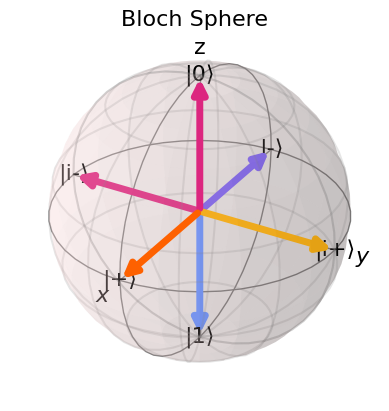

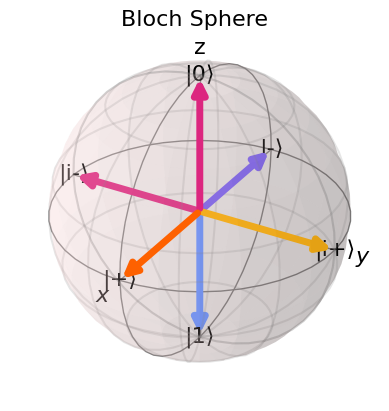

In [ ]:
plot_bloch_multiple_vector(bloch_states)

# Ejercicio 4

En cada ítem, crea una esfera de Bloch donde se visualicen los siguientes casos:

- Puerta X al qubit $|0\rangle$ y al qubit $|1\rangle$
- Puerta Y al qubit $|0\rangle$ y al qubit $|1\rangle$
- Puerta Z al qubit $|0\rangle$ y al qubit $|1\rangle$
- Puerta H al qubit $|0\rangle$ y al qubit $|1\rangle$

Definimos $|0\rangle$ y $|1\rangle$:

In [ ]:
ket_0 = np.array([[1], [0]])
ket_1 = np.array([[0], [1]])

Definimos las puertas X, Y, Z y H:

In [ ]:
matrix_x = np.array([[0, 1], [1, 0]])
matrix_y = np.array([[0, -1j], [1j, 0]])
matrix_z = np.array([[1, 0], [0, -1]])
matrix_h = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])

## Puerta X

La puerta Pauli-X aplica una operación de negación a un qubit. Matemáticamente, se puede describir de la siguiente manera:

$$
X|0\rangle = \begin{bmatrix}0 & 1 \\ 1 & 0\end{bmatrix}\begin{bmatrix}1 \\ 0\end{bmatrix} = \begin{bmatrix}0 \\ 1\end{bmatrix} = |1\rangle
$$

In [ ]:
pauli_x_0 = np.matmul(matrix_x, ket_0)
matrix_to_latex(pauli_x_0, prefix="X|0\\rangle =")

<IPython.core.display.Math object>

$$
X|1\rangle = \begin{bmatrix}0 & 1 \\ 1 & 0\end{bmatrix}\begin{bmatrix}0 \\ 1\end{bmatrix} = \begin{bmatrix}1 \\ 0\end{bmatrix} = |0\rangle
$$

In [ ]:
pauli_x_1 = np.matmul(matrix_x, ket_1)
matrix_to_latex(pauli_x_1, prefix="X|1\\rangle =")

<IPython.core.display.Math object>

Por lo tanto, definimos los estados al qubit $|0\rangle$ y $|1\rangle$:

In [ ]:
pauli_x = {
    "X|0⟩": compute_bloch_vector(pauli_x_0),
    "X|1⟩": compute_bloch_vector(pauli_x_1),
}
pauli_x

{'X|0⟩': [0, 0, -1], 'X|1⟩': [0, 0, 1]}

Y creamos la esfera de Bloch:

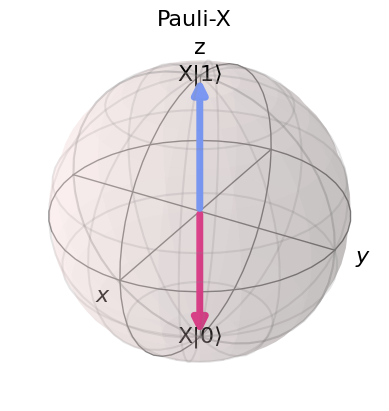

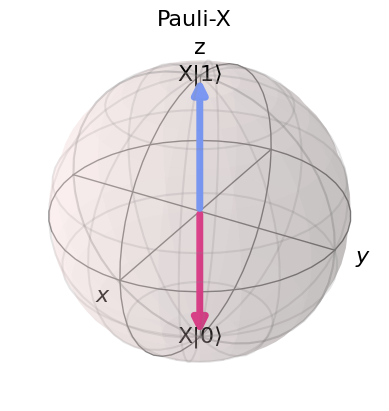

In [ ]:
plot_bloch_multiple_vector(pauli_x, title="Pauli-X")

## Puerta Y

La puerta Pauli-Y introduce una fase compleja a un qubit. Matemáticamente, se puede describir de la siguiente manera:

$$
Y|0\rangle = \begin{bmatrix}0 & -i \\ i & 0\end{bmatrix}\begin{bmatrix}1 \\ 0\end{bmatrix} = \begin{bmatrix}0 \\ i\end{bmatrix} = i|1\rangle
$$

In [ ]:
pauli_y_0 = np.matmul(matrix_y, ket_0)
matrix_to_latex(pauli_y_0, prefix="Y|0\\rangle =")

<IPython.core.display.Math object>

$$
Y|1\rangle = \begin{bmatrix}0 & -i \\ i & 0\end{bmatrix}\begin{bmatrix}0 \\ 1\end{bmatrix} = \begin{bmatrix}-i \\ 0\end{bmatrix} = -i|0\rangle
$$

In [ ]:
pauli_y_1 = np.matmul(matrix_y, ket_1)
matrix_to_latex(pauli_y_1, prefix="Y|1\\rangle =")

<IPython.core.display.Math object>

Por lo tanto, definimos los estados al qubit $|0\rangle$ y $|1\rangle$:

In [ ]:
pauli_y = {
    "Y|0⟩": compute_bloch_vector(pauli_y_0),
    "Y|1⟩": compute_bloch_vector(pauli_y_1),
}
pauli_y

{'Y|0⟩': [0.0, 0.0, -1.0], 'Y|1⟩': [0.0, 0.0, 1.0]}

Y creamos la esfera de Bloch:

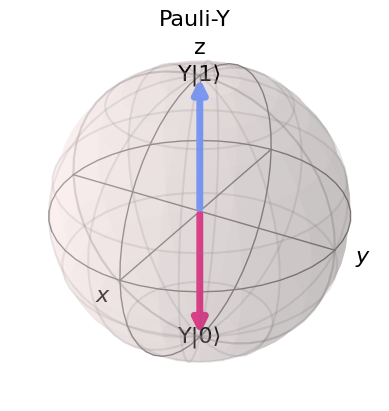

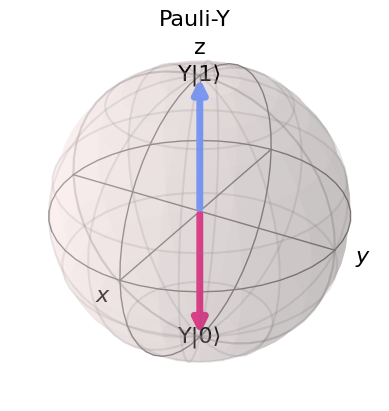

In [ ]:
plot_bloch_multiple_vector(pauli_y, title="Pauli-Y")

## Puerta Z

La puerta Pauli-Z aplica una fase global de $\pi$ al estado $|1\rangle$. Matemáticamente, se puede describir de la siguiente manera:

$$
Z|0\rangle = \begin{bmatrix}1 & 0 \\ 0 & -1\end{bmatrix}\begin{bmatrix}1 \\ 0\end{bmatrix} = \begin{bmatrix}1 \\ 0\end{bmatrix} = |0\rangle
$$

In [ ]:
pauli_z_0 = np.matmul(matrix_z, ket_0)
matrix_to_latex(pauli_z_0, prefix="Z|0\\rangle =")

<IPython.core.display.Math object>

$$
Z|1\rangle = \begin{bmatrix}1 & 0 \\ 0 & -1\end{bmatrix}\begin{bmatrix}0 \\ 1\end{bmatrix} = \begin{bmatrix}0 \\ -1\end{bmatrix} = -|1\rangle
$$

In [ ]:
pauli_z_1 = np.matmul(matrix_z, ket_1)
matrix_to_latex(pauli_z_1, prefix="Z|1\\rangle =")

<IPython.core.display.Math object>

Por lo tanto, definimos los estados al qubit $|0\rangle$ y $|1\rangle$:

In [ ]:
pauli_z = {
    "Z|0⟩": compute_bloch_vector(pauli_z_0),
    "Z|1⟩": compute_bloch_vector(pauli_z_1),
}
pauli_z

{'Z|0⟩': [0, 0, 1], 'Z|1⟩': [0, 0, -1]}

Y creamos la esfera de Bloch:

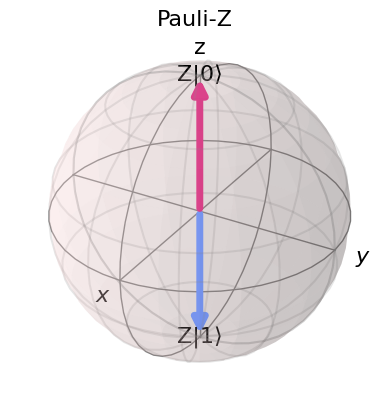

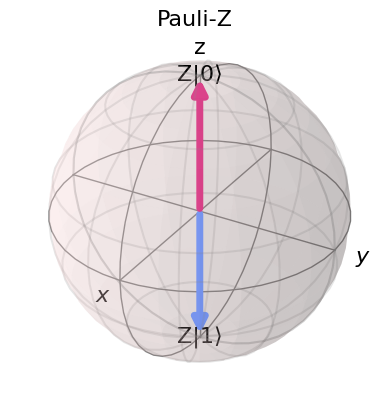

In [ ]:
plot_bloch_multiple_vector(pauli_z, title="Pauli-Z")

## Puerta H

La puerta Pauli-H (Hadamard) realiza una transformación de superposición, creando una superposición igual de $|0\rangle$ y $|1\rangle$. Matemáticamente, se puede describir de la siguiente manera:

$$
H|0\rangle = \frac{1}{\sqrt{2}}\begin{bmatrix}1 & 1 \\ 1 & -1\end{bmatrix}\begin{bmatrix}1 \\ 0\end{bmatrix} = \frac{1}{\sqrt{2}}\begin{bmatrix}1 \\ 1\end{bmatrix} = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)
$$

In [39]:
hadamard_0 = np.matmul(matrix_h, ket_0)
matrix_to_latex(hadamard_0, prefix="H|0\\rangle =")

<IPython.core.display.Math object>

$$
H|1\rangle = \frac{1}{\sqrt{2}}\begin{bmatrix}1 & 1 \\ 1 & -1\end{bmatrix}\begin{bmatrix}0 \\ 1\end{bmatrix} = \frac{1}{\sqrt{2}}\begin{bmatrix}1 \\ -1\end{bmatrix} = \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)
$$

In [40]:
hadamard_1 = np.matmul(matrix_h, ket_1)
matrix_to_latex(hadamard_1, prefix="H|1\\rangle =")

<IPython.core.display.Math object>

Por lo tanto, definimos los estados al qubit $|0\rangle$ y $|1\rangle$:

In [41]:
hadamard = {
    "H|0⟩": compute_bloch_vector(hadamard_0),
    "H|1⟩": compute_bloch_vector(hadamard_1),
}
hadamard

{'H|0⟩': [1.0, 0.0, 0.0], 'H|1⟩': [-1.0, 0.0, 0.0]}

Y creamos la esfera de Bloch:

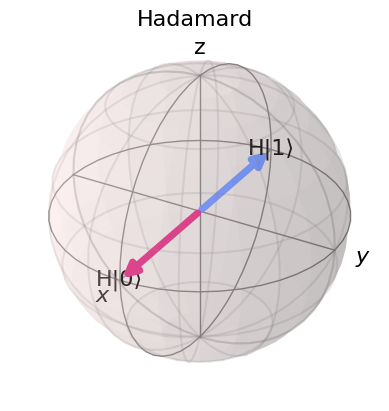

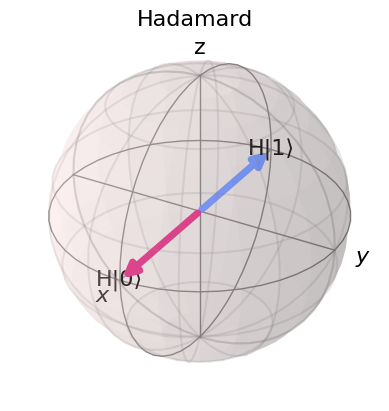

In [42]:
plot_bloch_multiple_vector(hadamard, title="Hadamard")